## Clustering the Riders
Intro etc.

In [1]:
import sys
sys.path.append("..")

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import mode
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from src.dbops import fetch_riders, fetch_stages, assign_clusters
from src.kmeans_selection import PREPROCESSORS, SPECIALTIES, compute_inertia_silhouette, plot_inertia_silhouette, model_summary

### Loading the Riders

In [3]:
project = ["name", "nationality", "weight", "height", "points"]
riders = fetch_riders(project=project)
riders = pd.json_normalize(riders)
riders.head()

,name,nationality,weight,height,points.classic,points.gc,points.tt,points.sprint,points.climber
0,david-zabriskie,United States,67.0,183.0,62,1058,3065,204,185
1,lance-armstrong,United States,72.0,178.0,3827,3642,3813,2732,1653
2,alexandre-vinokourov,Kazakhstan,68.0,177.0,3008,5726,4500,3510,3240
3,george-hincapie,United States,83.0,191.0,4618,2389,2331,4370,593
4,laszlo-bodrogi,France,NaN,187.0,828,1074,4949,796,76


### Exploring the Data

In [4]:
riders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1171 entries, 0 to 1170
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            1171 non-null   object 
 1   nationality     1171 non-null   object 
 2   weight          932 non-null    float64
 3   height          939 non-null    float64
 4   points.classic  1171 non-null   int64  
 5   points.gc       1171 non-null   int64  
 6   points.tt       1171 non-null   int64  
 7   points.sprint   1171 non-null   int64  
 8   points.climber  1171 non-null   int64  
dtypes: float64(2), int64(5), object(2)
memory usage: 82.5+ KB


In [5]:
riders["nationality"].value_counts().head()

Italy          236
Spain          144
France         143
Belgium         85
Netherlands     63
Name: nationality, dtype: int64

In [6]:
riders.describe()

,weight,height,points.classic,points.gc,points.tt,points.sprint,points.climber
count,932.000000,939.000000,1171.000000,1171.000000,1171.000000,1171.000000,1171.000000
mean,68.057983,179.726305,994.624253,1108.163962,577.475662,1361.237404,675.163962
std,7.428277,6.302490,1413.888983,1359.737744,1053.506435,1941.494461,1132.370307
min,1.780000,159.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,64.000000,175.000000,235.000000,310.500000,45.000000,308.500000,91.500000
50%,68.000000,180.000000,537.000000,647.000000,172.000000,741.000000,275.000000
75%,73.000000,184.000000,1148.000000,1316.000000,606.000000,1568.500000,746.000000
max,94.000000,199.000000,15680.000000,12409.000000,10687.000000,22714.000000,13660.000000


### Selecting the Best K-Means Model
#### Plotting the Inertia & Silhouette Score for Different Strategies

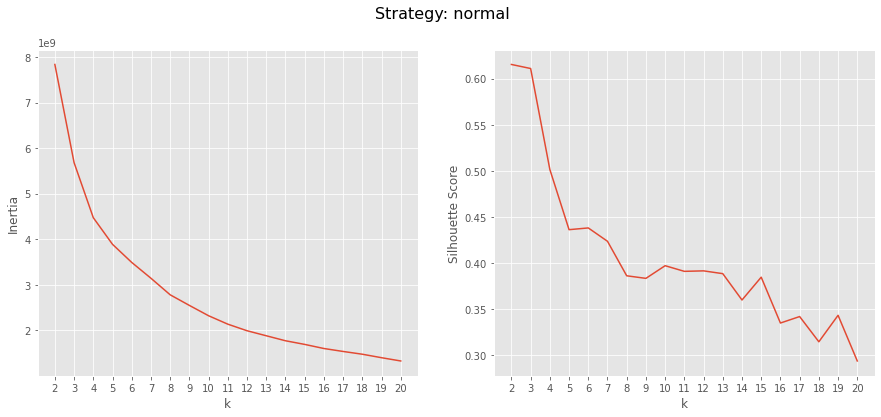

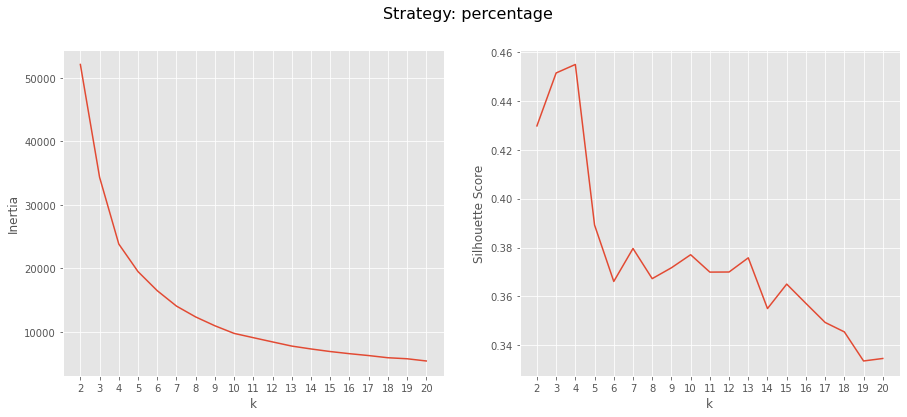

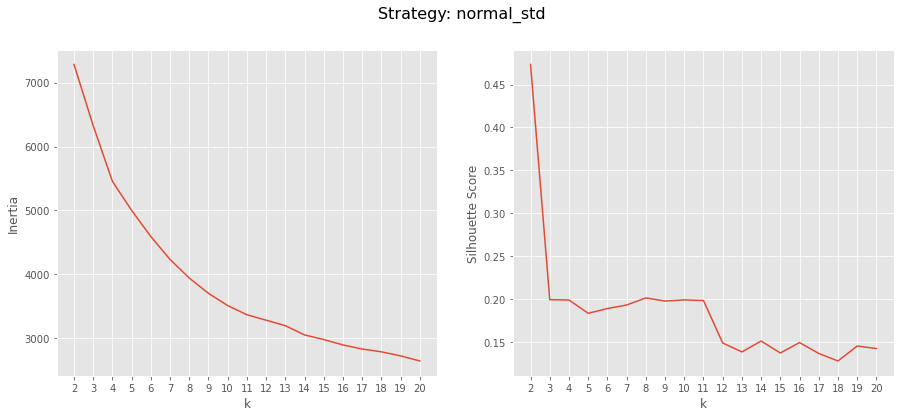

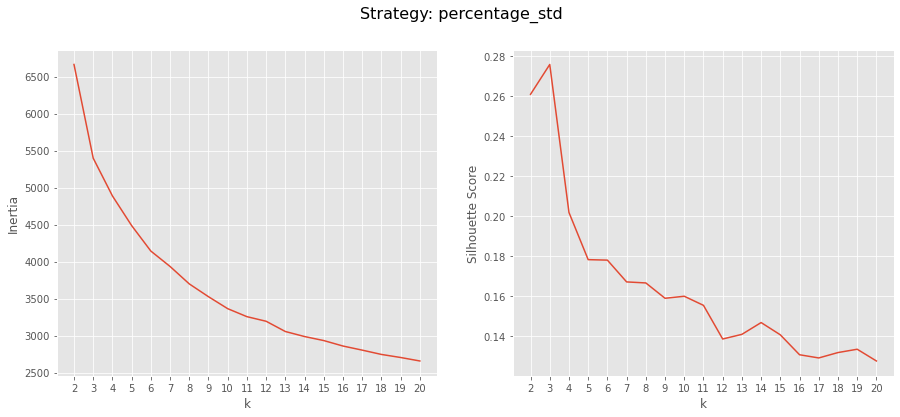

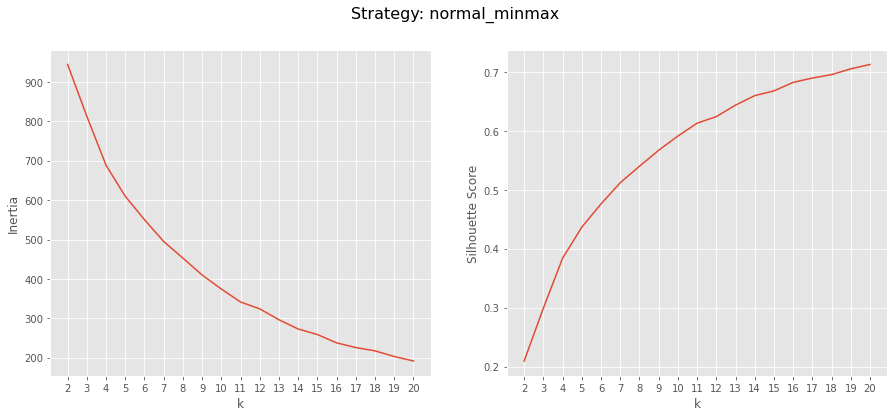

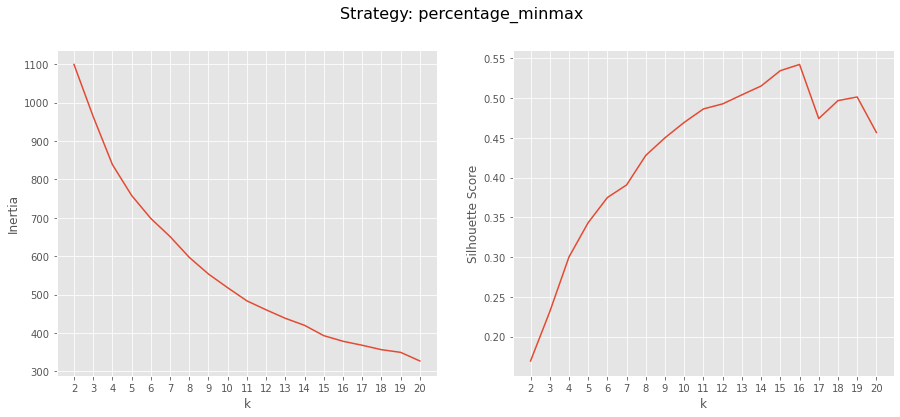

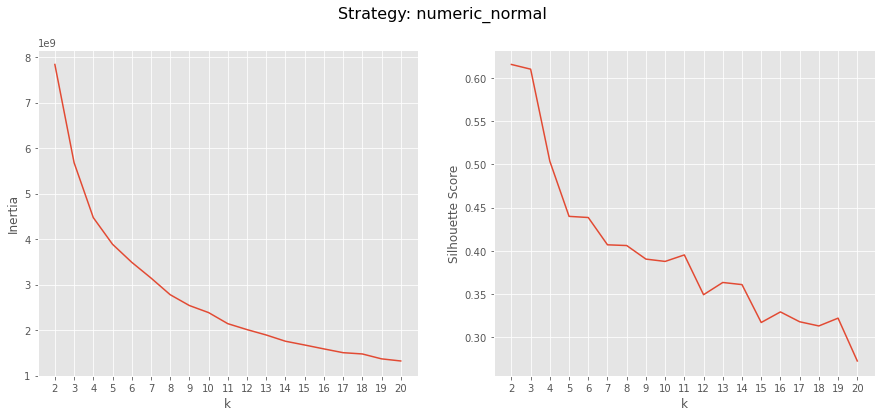

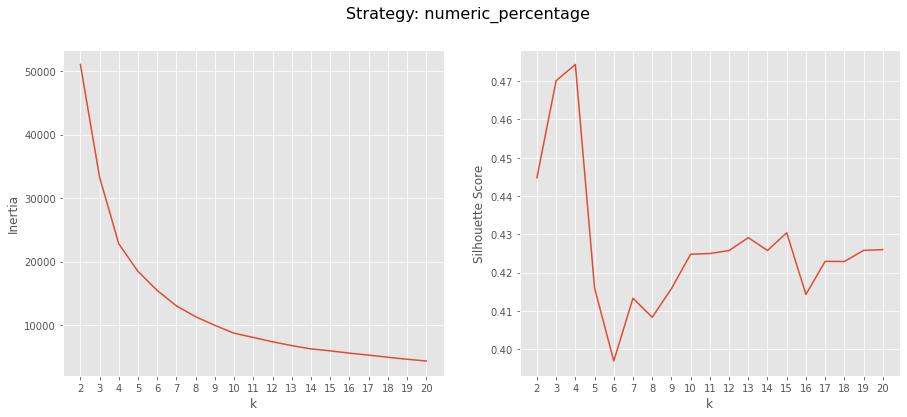

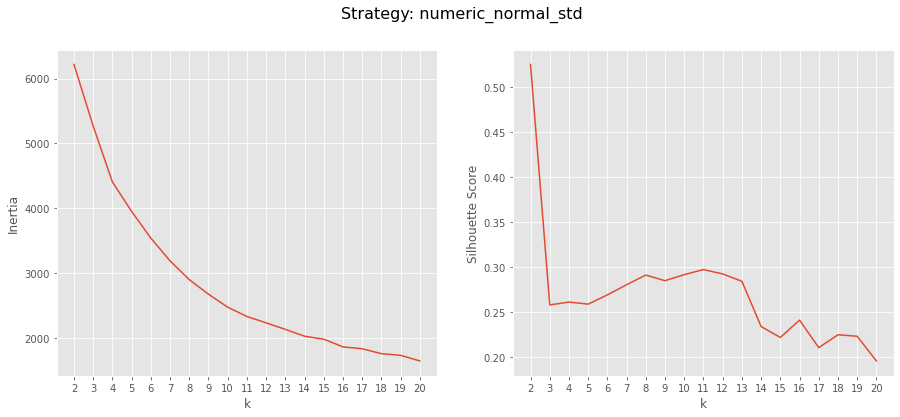

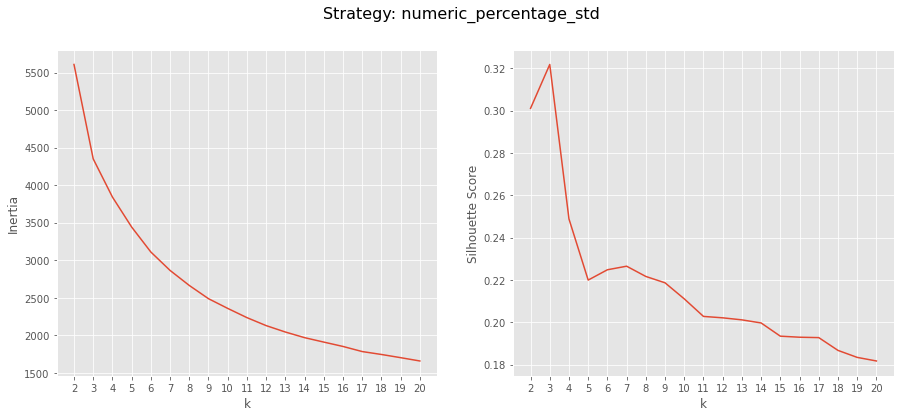

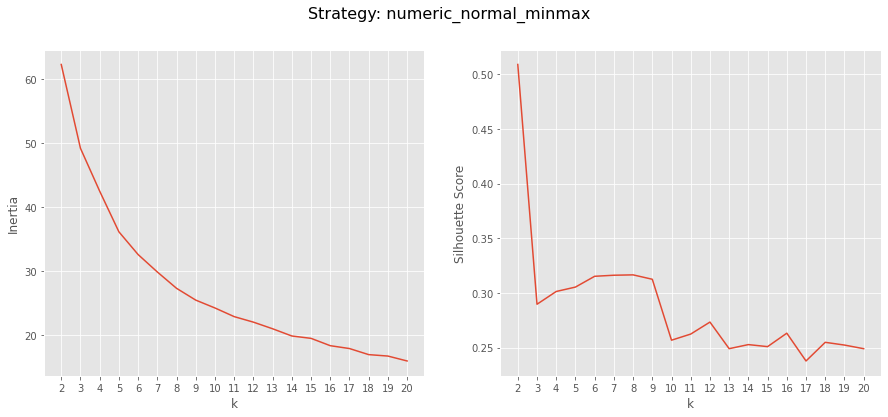

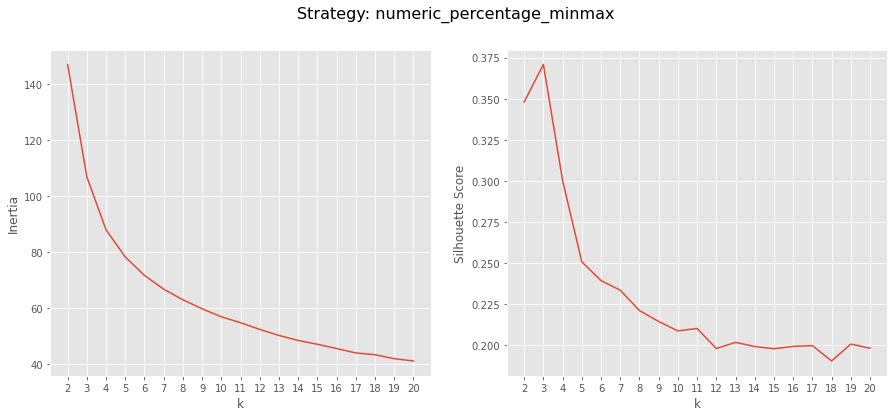

In [7]:
for strategy, preprocessor in PREPROCESSORS.items():
    inertia, silhouette = compute_inertia_silhouette(riders, preprocessor)
    plot_inertia_silhouette(inertia, silhouette, strategy)

#### Inspecting the Most Promising Combinations

In [ ]:
# Summary for strat=normal, k=6
model_summary(riders, "normal", 6)

In [ ]:
# Summary for strat=normal_, k=8
model_summary(riders, "normal", 8)

In [ ]:
# Summary for strat=normal, k=10
model_summary(riders, "normal", 10)

In [ ]:
# Summary for strat=percentage, k=10
model_summary(riders, "percentage", 10)

In [ ]:
# Summary for strat=normal_std, k=10
model_summary(riders, "normal_std", 10)

In [ ]:
# Summary for strat=percentage_std, k=7
model_summary(riders, "percentage_std", 7)

In [ ]:
# Summary for strat=normal_minmax, k=7
model_summary(riders, "normal_minmax", 7)

In [ ]:
# Summary for strat=normal_minmax, k=11
model_summary(riders, "normal_minmax", 11)

In [ ]:
# Summary for strat=percentage_minmax, k=8
model_summary(riders, "percentage_minmax", 8)

In [ ]:
# Summary for strat=percentage_minmax, k=12
model_summary(riders, "percentage_minmax", 12)

In [ ]:
# Summary for strat=numeric_normal, k=5
model_summary(riders, "numeric_normal", 5)

In [ ]:
# Summary for strat=numeric_normal, k=10
model_summary(riders, "numeric_normal", 10)

In [ ]:
# Summary for strat=numeric_percentage, k=10
model_summary(riders, "numeric_percentage", 10)

In [ ]:
# Summary for strat=numeric_normal_std, k=9
model_summary(riders, "numeric_normal_std", 9)

In [ ]:
# Summary for strat=numeric_percentage_std, k=7
model_summary(riders, "numeric_percentage_std", 7)

In [ ]:
# Summary for strat=numeric_normal_minmax, k=9
model_summary(riders, "numeric_normal_minmax", 9)

#### Final Selection and Rider Clustering

In [8]:
# Define model and do clustering
pipeline = Pipeline([
    ("preprocessor", PREPROCESSORS["numeric_percentage_std"]),
    ("kmeans", KMeans(n_clusters=7)),
])
pipeline.fit(riders)

riders["cluster"] = pipeline["kmeans"].labels_

In [9]:
assign_clusters(riders)

### Looking at the Number of Stages by Clusters
#### Assigning the Stage to the Winner's Cluster

In [10]:
# Load stages
project = ["time_trial", "result"]
stages = fetch_stages(project=project)
stages = pd.DataFrame(stages)
stages.head()

,time_trial,result
0,True,"[david-zabriskie, lance-armstrong, alexandre-v..."
1,False,"[tom-boonen, thor-hushovd, robbie-mcewen, stua..."
2,False,"[tom-boonen, peter-wrolich, stuart-o-grady, be..."
3,False,"[robbie-mcewen, tom-boonen, thor-hushovd, stua..."
4,False,"[lorenzo-bernucci, alexandre-vinokourov, rober..."


In [11]:
stages["winner"] = stages["result"].transform(lambda x: x[0])
stages_winner = stages.merge(riders, left_on="winner", right_on="name")

In [12]:
stages_winner.groupby("cluster").agg({"winner": "count"})

,winner
cluster,
0,48
1,211
2,234
3,181
4,139
5,147
6,96


#### Assigning the Stage to the Mode of the First 10 Riders' Clusters

In [13]:
def get_clusters(result):
    clusters = []
    for rider in result:
        mask = (riders["name"] == rider)
        cluster = riders[mask]["cluster"]
        clusters.append(cluster)
    return np.array(clusters, dtype="uint8")

stages["result_clusters"] = stages["result"].transform(lambda result: get_clusters(result))

In [14]:
stages["cluster_mode"] = stages["result_clusters"].transform(lambda x: mode(x, axis=None).mode[0])

In [15]:
stages.groupby("cluster_mode").agg({"result": "count"})

,result
cluster_mode,
0,36
1,296
2,287
3,187
4,115
5,78
6,57


Decision: assign the stage the cluster of the winner, as the classes are more balanced.

### Visualizing the Clusters with Umap

In [16]:
# UMAP
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [17]:
riders_umap = riders[["weight", "height"] + SPECIALTIES]

In [18]:
pipe = Pipeline([
    ("preprocessor", PREPROCESSORS["numeric_percentage_std"]),
    ("umap", umap.UMAP(n_components=3))
])

In [19]:
embbeding = pipe.fit_transform(riders_umap)

In [20]:
embbeding.shape

(1171, 3)

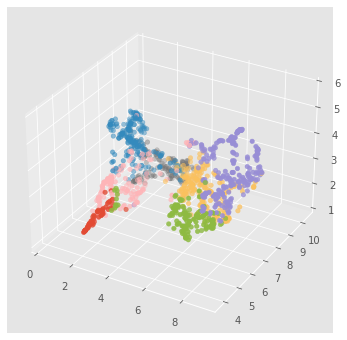

In [21]:
ax = plt.axes(projection="3d")
ax.scatter3D(
    embbeding[:, 0],
    embbeding[:, 1],
    embbeding[:, 2],
    c=[sns.color_palette()[x] for x in riders["cluster"]]
)